<a href="https://colab.research.google.com/github/Pedro-Ortega-G/pet_unet/blob/main/Pet_Unet_0c53f9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
lucasiturriago_oxfordiiitpet_path = kagglehub.dataset_download('lucasiturriago/oxfordiiitpet')

print('Data source import complete.')


In [ ]:
%%capture
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.image_segmentation.git

In [ ]:
!mkdir -p ./datasets/OxfordIIITPet && cp -r /kaggle/input/oxfordiiitpet/annotations /kaggle/input/oxfordiiitpet/images ./datasets/OxfordIIITPet

In [ ]:
import os
import re
import glob
import shutil
import numpy as np
from PIL import Image
from functools import partial
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import backend as K
from keras.optimizers import Adam
from tensorflow.keras.losses import Loss
from tensorflow.keras.metrics import Metric
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras import Model, layers, regularizers
from gcpds.image_segmentation.models import unet_baseline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
class CustomDataLoader:

    def __init__(self, data_dir, batch_size, image_size, train_split=0.7, val_split=0.15, test_split=0.15):

        self.data_dir = data_dir
        self.batch_size = batch_size
        self.image_size = image_size

        # Verificar que los porcentajes sumen 1.0
        total_split = train_split + val_split + test_split
        if abs(total_split - 1.0) > 1e-6:
            raise ValueError(f"Los porcentajes de split deben sumar 1.0, pero suman {total_split}")

        self.train_split = train_split
        self.val_split = val_split
        self.test_split = test_split

    def load_patch_images(self):
        # Create the path for patch images
        patch_path_pattern = os.path.join(self.data_dir, 'images', '*.jpg')
        patch_files = glob.glob(patch_path_pattern)

        # Key function to convert numbers in strings to integers for sorting
        def alphanumeric_key(s):
            # Split the string into parts (numbers and text)
            parts = re.split(r'(\d+)', s)
            # Convert numeric parts to integers, leaving non-numeric parts unchanged
            return [int(part) if part.isdigit() else part for part in parts]

        patch_files = sorted(patch_files, key=alphanumeric_key)
        # Print the complete path and the number of found patch images
        print(f"Complete path for patches: {patch_path_pattern}")
        print(f"Number of images files found: {len(patch_files)}")
        # Create a TensorFlow dataset from the patch file paths
        patch_ds = tf.data.Dataset.from_tensor_slices(patch_files)
        # Map each file path to a processed image
        patch_ds = patch_ds.map(self.process_patch, num_parallel_calls=tf.data.AUTOTUNE)
        return patch_ds, len(patch_files)

    def load_masks(self):

        # Create the path for masks images
        masks_path_pattern = os.path.join(self.data_dir, 'annotations', '*.png')
        masks_files = glob.glob(masks_path_pattern)

        # Key function to convert numbers in strings to integers for sorting
        def alphanumeric_key(s):
            # Split the string into parts (numbers and text)
            parts = re.split(r'(\d+)', s)
            # Convert numeric parts to integers, leaving non-numeric parts unchanged
            return [int(part) if part.isdigit() else part for part in parts]

        masks_files = sorted(masks_files, key=alphanumeric_key)
        # Print the complete path and the number of found masks images
        print(f"Complete path for masks: {masks_path_pattern}")
        print(f"Number of images files found: {len(masks_files)}")
        # Create a TensorFlow dataset from the patch file paths
        masks_ds = tf.data.Dataset.from_tensor_slices(masks_files)
        # Map each file path to a processed image
        masks_ds = masks_ds.map(self.process_masks, num_parallel_calls=tf.data.AUTOTUNE)
        return masks_ds, len(masks_files)

    def process_patch(self, file_path):
        img = tf.io.read_file(file_path)  # Read the image file
        img = tf.image.decode_jpeg(img, channels=3)  # Decode JPEG image
        img = tf.image.resize(img, self.image_size)  # Resize image
        img /= 255.0  # Normalize to [0, 1]
        return img

    def process_masks(self, file_path):
        img = tf.io.read_file(file_path)  # Read the image file
        img = tf.image.decode_png(img, channels=1)  # Decode PNG masks
        img = tf.image.resize(img, self.image_size)  # Resize image
        img /= 255.0  # Normalize to [0, 1]
        return img

    def get_dataset_partitions(self):
        # Load patches and masks
        patch_ds, n_patches = self.load_patch_images()
        mask_ds, n_masks = self.load_masks()

        # Verificar que tenemos el mismo número de imágenes y máscaras
        if n_patches != n_masks:
            raise ValueError(f"El número de imágenes ({n_patches}) y máscaras ({n_masks}) no coincide")

        # Combine patches and masks
        dataset = tf.data.Dataset.zip((patch_ds, mask_ds))

        # Calcular el número de elementos para cada partición
        n_total = n_patches
        n_train = int(n_total * self.train_split)
        n_val = int(n_total * self.val_split)
        n_test = n_total - n_train - n_val

        # Mezclar el dataset completo antes de particionarlo
        dataset = dataset.shuffle(buffer_size=n_total, seed=42, reshuffle_each_iteration=False)

        # Particionar el dataset
        train_ds = dataset.take(n_train)
        temp_ds = dataset.skip(n_train)
        val_ds = temp_ds.take(n_val)
        test_ds = temp_ds.skip(n_val)

        # Aplicar batch y prefetch a cada partición
        train_ds = train_ds.batch(self.batch_size).prefetch(tf.data.AUTOTUNE)
        val_ds = val_ds.batch(self.batch_size).prefetch(tf.data.AUTOTUNE)
        test_ds = test_ds.batch(self.batch_size).prefetch(tf.data.AUTOTUNE)

        print(f"Dataset particionado en: train={n_train} imágenes, validation={n_val} imágenes, test={n_test} imágenes")

        return train_ds, val_ds, test_ds

    def get_dataset(self):
        # Mantener el método anterior para compatibilidad
        # Load patches and masks
        patch_ds, _ = self.load_patch_images()
        mask_ds, _ = self.load_masks()

        # Combine patches and masks, apply batching and prefetching
        dataset = tf.data.Dataset.zip((patch_ds, mask_ds))
        dataset = dataset.batch(self.batch_size).prefetch(tf.data.AUTOTUNE)
        return dataset

In [ ]:
# Crear una instancia del dataloader con porcentajes personalizados
dataloader = CustomDataLoader(
    data_dir='/kaggle/working/datasets/OxfordIIITPet',
    batch_size=64,
    image_size=(128, 128),
    train_split=0.8,   # 80% para entrenamiento
    val_split=0.1,     # 10% para validación
    test_split=0.1     # 10% para pruebas
)

# Obtener las particiones
train_ds, val_ds, test_ds = dataloader.get_dataset_partitions()

Complete path for patches: /kaggle/working/datasets/OxfordIIITPet/images/*.jpg
Number of images files found: 7390
Complete path for masks: /kaggle/working/datasets/OxfordIIITPet/annotations/*.png
Number of images files found: 7390
Dataset particionado en: train=5912 imágenes, validation=739 imágenes, test=739 imágenes


In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true), axis=-1) + K.sum(K.square(y_pred), axis=-1) + smooth)



In [ ]:
def dice_metric(y_true, y_pred, smooth=1e-7, axis=(1, 2), return_mean=True):
    y_true = tf.cast(y_true, tf.float32)
    y_true = tf.where(y_true > 0.5, 1.0, 0.0)
    y_pred = tf.cast(y_pred, tf.float32)
    y_pred = tf.where(y_pred > 0.5, 1.0, 0.0)
    intersection = tf.reduce_sum(y_true * y_pred, axis=axis)
    union = tf.reduce_sum(y_true, axis=axis) + tf.reduce_sum(y_pred, axis=axis)
    dice = (2. * intersection + smooth) / (union + smooth)

    if return_mean:
        return tf.reduce_mean(dice)
    else:
        return tf.squeeze(tf.transpose(dice, perm=[1, 0]), axis=0)

class DiceCoefficient(Loss):
    def __init__(self, smooth=1e-4, target_class= None, name='DiceCoefficient', **kwargs):
        self.smooth = smooth
        self.target_class = target_class
        super().__init__(name=name,**kwargs)

    def call(self, y_true, y_pred):
        intersection = K.sum(y_true * y_pred, axis=[1,2])
        union = K.sum(y_true,axis=[1,2]) + K.sum(y_pred,axis=[1,2])
        dice_coef = -(2. * intersection + self.smooth) /(union + self.smooth)

        if self.target_class != None:
            dice_coef = tf.gather(dice_coef,
                                  self.target_class, axis=1)
        else:
            dice_coef = K.mean(dice_coef,axis=-1)

        return dice_coef

    def get_config(self,):
        base_config = super().get_config()
        return {**base_config, "smooth": self.smooth,
                "target_class":self.target_class}

In [ ]:
model= unet_baseline()
model.compile(optimizer=Adam(learning_rate=1e-4), loss=DiceCoefficient(), metrics=['accuracy',dice_metric])

In [ ]:
model.fit(train_ds, validation_data=val_ds, epochs=100)

Epoch 1/100


2025-03-06 21:32:46.461282: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inSelectV2_1-1-TransposeNHWCToNCHW-LayoutOptimizer
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - ETA: 0s - loss: -0.5942 - accuracy: 0.6873 - dice_metric: 0.6344

2025-03-06 21:33:07.211338: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inSelectV2_1-1-TransposeNHWCToNCHW-LayoutOptimizer
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 32s 201ms/step - loss: -0.5942 - accuracy: 0.6873 - dice_metric: 0.6344 - val_loss: -0.3449 - val_accuracy: 0.6343 - val_dice_metric: 0.3087
Epoch 2/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.6754 - accuracy: 0.7672 - dice_metric: 0.7220

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 191ms/step - loss: -0.6752 - accuracy: 0.7672 - dice_metric: 0.7217 - val_loss: -0.6620 - val_accuracy: 0.6768 - val_dice_metric: 0.6677
Epoch 3/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.6941 - accuracy: 0.7830 - dice_metric: 0.7409

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 186ms/step - loss: -0.6940 - accuracy: 0.7830 - dice_metric: 0.7407 - val_loss: -0.7031 - val_accuracy: 0.7368 - val_dice_metric: 0.7064
Epoch 4/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.7028 - accuracy: 0.7906 - dice_metric: 0.7497

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 186ms/step - loss: -0.7027 - accuracy: 0.7906 - dice_metric: 0.7495 - val_loss: -0.6989 - val_accuracy: 0.7305 - val_dice_metric: 0.7029
Epoch 5/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.7147 - accuracy: 0.7968 - dice_metric: 0.7603

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 27s 186ms/step - loss: -0.7147 - accuracy: 0.7968 - dice_metric: 0.7602 - val_loss: -0.7162 - val_accuracy: 0.7706 - val_dice_metric: 0.7234
Epoch 6/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.7227 - accuracy: 0.7999 - dice_metric: 0.7666

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 183ms/step - loss: -0.7227 - accuracy: 0.7999 - dice_metric: 0.7665 - val_loss: -0.7283 - val_accuracy: 0.7722 - val_dice_metric: 0.7400
Epoch 7/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.7242 - accuracy: 0.7991 - dice_metric: 0.7667

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 186ms/step - loss: -0.7242 - accuracy: 0.7991 - dice_metric: 0.7667 - val_loss: -0.7204 - val_accuracy: 0.7617 - val_dice_metric: 0.7308
Epoch 8/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.7243 - accuracy: 0.7976 - dice_metric: 0.7656

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 187ms/step - loss: -0.7244 - accuracy: 0.7977 - dice_metric: 0.7657 - val_loss: -0.7299 - val_accuracy: 0.7719 - val_dice_metric: 0.7366
Epoch 9/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.7331 - accuracy: 0.8054 - dice_metric: 0.7726

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 185ms/step - loss: -0.7331 - accuracy: 0.8054 - dice_metric: 0.7724 - val_loss: -0.7306 - val_accuracy: 0.7639 - val_dice_metric: 0.7333
Epoch 10/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.7450 - accuracy: 0.8149 - dice_metric: 0.7820

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 187ms/step - loss: -0.7450 - accuracy: 0.8150 - dice_metric: 0.7819 - val_loss: -0.7421 - val_accuracy: 0.7727 - val_dice_metric: 0.7436
Epoch 11/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.7526 - accuracy: 0.8230 - dice_metric: 0.7890

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 183ms/step - loss: -0.7526 - accuracy: 0.8231 - dice_metric: 0.7890 - val_loss: -0.7584 - val_accuracy: 0.7856 - val_dice_metric: 0.7572
Epoch 12/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.7599 - accuracy: 0.8298 - dice_metric: 0.7957

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 186ms/step - loss: -0.7599 - accuracy: 0.8299 - dice_metric: 0.7957 - val_loss: -0.7636 - val_accuracy: 0.7916 - val_dice_metric: 0.7629
Epoch 13/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.7674 - accuracy: 0.8368 - dice_metric: 0.8029

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 190ms/step - loss: -0.7674 - accuracy: 0.8368 - dice_metric: 0.8029 - val_loss: -0.7656 - val_accuracy: 0.7968 - val_dice_metric: 0.7657
Epoch 14/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.7734 - accuracy: 0.8419 - dice_metric: 0.8082

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 187ms/step - loss: -0.7734 - accuracy: 0.8420 - dice_metric: 0.8083 - val_loss: -0.7677 - val_accuracy: 0.8013 - val_dice_metric: 0.7689
Epoch 15/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.7790 - accuracy: 0.8469 - dice_metric: 0.8134

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 186ms/step - loss: -0.7791 - accuracy: 0.8470 - dice_metric: 0.8135 - val_loss: -0.7718 - val_accuracy: 0.8055 - val_dice_metric: 0.7731
Epoch 16/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.7840 - accuracy: 0.8503 - dice_metric: 0.8173

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 182ms/step - loss: -0.7841 - accuracy: 0.8504 - dice_metric: 0.8175 - val_loss: -0.7743 - val_accuracy: 0.8080 - val_dice_metric: 0.7755
Epoch 17/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.7879 - accuracy: 0.8531 - dice_metric: 0.8204

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 184ms/step - loss: -0.7880 - accuracy: 0.8532 - dice_metric: 0.8206 - val_loss: -0.7750 - val_accuracy: 0.8078 - val_dice_metric: 0.7760
Epoch 18/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.7917 - accuracy: 0.8558 - dice_metric: 0.8233

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 185ms/step - loss: -0.7918 - accuracy: 0.8558 - dice_metric: 0.8234 - val_loss: -0.7764 - val_accuracy: 0.8093 - val_dice_metric: 0.7772
Epoch 19/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.7954 - accuracy: 0.8582 - dice_metric: 0.8259

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 187ms/step - loss: -0.7954 - accuracy: 0.8583 - dice_metric: 0.8261 - val_loss: -0.7799 - val_accuracy: 0.8138 - val_dice_metric: 0.7802
Epoch 20/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.7989 - accuracy: 0.8607 - dice_metric: 0.8287

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 186ms/step - loss: -0.7989 - accuracy: 0.8607 - dice_metric: 0.8289 - val_loss: -0.7826 - val_accuracy: 0.8176 - val_dice_metric: 0.7830
Epoch 21/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8025 - accuracy: 0.8632 - dice_metric: 0.8316

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 182ms/step - loss: -0.8025 - accuracy: 0.8633 - dice_metric: 0.8317 - val_loss: -0.7840 - val_accuracy: 0.8201 - val_dice_metric: 0.7849
Epoch 22/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8055 - accuracy: 0.8652 - dice_metric: 0.8339

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 183ms/step - loss: -0.8056 - accuracy: 0.8653 - dice_metric: 0.8341 - val_loss: -0.7847 - val_accuracy: 0.8213 - val_dice_metric: 0.7860
Epoch 23/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8080 - accuracy: 0.8669 - dice_metric: 0.8358

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 186ms/step - loss: -0.8080 - accuracy: 0.8670 - dice_metric: 0.8360 - val_loss: -0.7839 - val_accuracy: 0.8230 - val_dice_metric: 0.7860
Epoch 24/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8104 - accuracy: 0.8685 - dice_metric: 0.8376

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 188ms/step - loss: -0.8105 - accuracy: 0.8686 - dice_metric: 0.8378 - val_loss: -0.7849 - val_accuracy: 0.8246 - val_dice_metric: 0.7872
Epoch 25/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8123 - accuracy: 0.8696 - dice_metric: 0.8390

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 192ms/step - loss: -0.8124 - accuracy: 0.8697 - dice_metric: 0.8391 - val_loss: -0.7836 - val_accuracy: 0.8243 - val_dice_metric: 0.7858
Epoch 26/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8143 - accuracy: 0.8708 - dice_metric: 0.8403

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 184ms/step - loss: -0.8143 - accuracy: 0.8708 - dice_metric: 0.8404 - val_loss: -0.7829 - val_accuracy: 0.8255 - val_dice_metric: 0.7853
Epoch 27/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8171 - accuracy: 0.8726 - dice_metric: 0.8424

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 180ms/step - loss: -0.8171 - accuracy: 0.8726 - dice_metric: 0.8425 - val_loss: -0.7836 - val_accuracy: 0.8264 - val_dice_metric: 0.7860
Epoch 28/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8191 - accuracy: 0.8737 - dice_metric: 0.8437

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 186ms/step - loss: -0.8191 - accuracy: 0.8737 - dice_metric: 0.8438 - val_loss: -0.7849 - val_accuracy: 0.8287 - val_dice_metric: 0.7878
Epoch 29/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8208 - accuracy: 0.8747 - dice_metric: 0.8449

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 25s 180ms/step - loss: -0.8209 - accuracy: 0.8747 - dice_metric: 0.8450 - val_loss: -0.7892 - val_accuracy: 0.8326 - val_dice_metric: 0.7919
Epoch 30/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8236 - accuracy: 0.8767 - dice_metric: 0.8473

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 190ms/step - loss: -0.8237 - accuracy: 0.8768 - dice_metric: 0.8475 - val_loss: -0.7909 - val_accuracy: 0.8336 - val_dice_metric: 0.7937
Epoch 31/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8257 - accuracy: 0.8780 - dice_metric: 0.8489

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 184ms/step - loss: -0.8257 - accuracy: 0.8781 - dice_metric: 0.8491 - val_loss: -0.7907 - val_accuracy: 0.8333 - val_dice_metric: 0.7933
Epoch 32/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8276 - accuracy: 0.8792 - dice_metric: 0.8504

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 181ms/step - loss: -0.8277 - accuracy: 0.8793 - dice_metric: 0.8506 - val_loss: -0.7914 - val_accuracy: 0.8336 - val_dice_metric: 0.7937
Epoch 33/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8295 - accuracy: 0.8803 - dice_metric: 0.8518

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 185ms/step - loss: -0.8296 - accuracy: 0.8804 - dice_metric: 0.8520 - val_loss: -0.7901 - val_accuracy: 0.8328 - val_dice_metric: 0.7921
Epoch 34/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8313 - accuracy: 0.8814 - dice_metric: 0.8533

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 25s 181ms/step - loss: -0.8314 - accuracy: 0.8815 - dice_metric: 0.8534 - val_loss: -0.7891 - val_accuracy: 0.8324 - val_dice_metric: 0.7909
Epoch 35/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8328 - accuracy: 0.8822 - dice_metric: 0.8543

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 192ms/step - loss: -0.8328 - accuracy: 0.8823 - dice_metric: 0.8545 - val_loss: -0.7897 - val_accuracy: 0.8328 - val_dice_metric: 0.7910
Epoch 36/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8342 - accuracy: 0.8830 - dice_metric: 0.8553

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 188ms/step - loss: -0.8342 - accuracy: 0.8831 - dice_metric: 0.8554 - val_loss: -0.7899 - val_accuracy: 0.8330 - val_dice_metric: 0.7911
Epoch 37/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8355 - accuracy: 0.8838 - dice_metric: 0.8563

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 182ms/step - loss: -0.8356 - accuracy: 0.8839 - dice_metric: 0.8565 - val_loss: -0.7902 - val_accuracy: 0.8324 - val_dice_metric: 0.7911
Epoch 38/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8370 - accuracy: 0.8847 - dice_metric: 0.8575

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 186ms/step - loss: -0.8370 - accuracy: 0.8848 - dice_metric: 0.8576 - val_loss: -0.7912 - val_accuracy: 0.8335 - val_dice_metric: 0.7919
Epoch 39/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8381 - accuracy: 0.8852 - dice_metric: 0.8582

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 183ms/step - loss: -0.8381 - accuracy: 0.8852 - dice_metric: 0.8583 - val_loss: -0.7915 - val_accuracy: 0.8342 - val_dice_metric: 0.7924
Epoch 40/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8389 - accuracy: 0.8854 - dice_metric: 0.8585

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 188ms/step - loss: -0.8389 - accuracy: 0.8855 - dice_metric: 0.8586 - val_loss: -0.7914 - val_accuracy: 0.8330 - val_dice_metric: 0.7920
Epoch 41/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8400 - accuracy: 0.8860 - dice_metric: 0.8593

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 193ms/step - loss: -0.8400 - accuracy: 0.8861 - dice_metric: 0.8594 - val_loss: -0.7901 - val_accuracy: 0.8301 - val_dice_metric: 0.7903
Epoch 42/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8420 - accuracy: 0.8873 - dice_metric: 0.8610

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 183ms/step - loss: -0.8420 - accuracy: 0.8874 - dice_metric: 0.8611 - val_loss: -0.7902 - val_accuracy: 0.8287 - val_dice_metric: 0.7899
Epoch 43/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8439 - accuracy: 0.8886 - dice_metric: 0.8625

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 186ms/step - loss: -0.8440 - accuracy: 0.8886 - dice_metric: 0.8626 - val_loss: -0.7894 - val_accuracy: 0.8273 - val_dice_metric: 0.7888
Epoch 44/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8460 - accuracy: 0.8900 - dice_metric: 0.8643

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 184ms/step - loss: -0.8460 - accuracy: 0.8901 - dice_metric: 0.8644 - val_loss: -0.7896 - val_accuracy: 0.8275 - val_dice_metric: 0.7890
Epoch 45/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8479 - accuracy: 0.8914 - dice_metric: 0.8659

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 182ms/step - loss: -0.8480 - accuracy: 0.8915 - dice_metric: 0.8661 - val_loss: -0.7930 - val_accuracy: 0.8303 - val_dice_metric: 0.7920
Epoch 46/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8497 - accuracy: 0.8927 - dice_metric: 0.8674

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 191ms/step - loss: -0.8497 - accuracy: 0.8928 - dice_metric: 0.8676 - val_loss: -0.7948 - val_accuracy: 0.8325 - val_dice_metric: 0.7936
Epoch 47/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8514 - accuracy: 0.8940 - dice_metric: 0.8688

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 25s 180ms/step - loss: -0.8514 - accuracy: 0.8940 - dice_metric: 0.8690 - val_loss: -0.7964 - val_accuracy: 0.8345 - val_dice_metric: 0.7953
Epoch 48/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8530 - accuracy: 0.8952 - dice_metric: 0.8703

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 186ms/step - loss: -0.8531 - accuracy: 0.8952 - dice_metric: 0.8705 - val_loss: -0.7976 - val_accuracy: 0.8357 - val_dice_metric: 0.7964
Epoch 49/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8546 - accuracy: 0.8962 - dice_metric: 0.8716

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 27s 188ms/step - loss: -0.8546 - accuracy: 0.8963 - dice_metric: 0.8717 - val_loss: -0.7984 - val_accuracy: 0.8370 - val_dice_metric: 0.7971
Epoch 50/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8560 - accuracy: 0.8973 - dice_metric: 0.8728

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 182ms/step - loss: -0.8561 - accuracy: 0.8973 - dice_metric: 0.8730 - val_loss: -0.7983 - val_accuracy: 0.8370 - val_dice_metric: 0.7968
Epoch 51/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8577 - accuracy: 0.8982 - dice_metric: 0.8741

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 27s 191ms/step - loss: -0.8577 - accuracy: 0.8983 - dice_metric: 0.8742 - val_loss: -0.7970 - val_accuracy: 0.8369 - val_dice_metric: 0.7956
Epoch 52/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8592 - accuracy: 0.8992 - dice_metric: 0.8753

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 188ms/step - loss: -0.8592 - accuracy: 0.8992 - dice_metric: 0.8755 - val_loss: -0.7943 - val_accuracy: 0.8355 - val_dice_metric: 0.7927
Epoch 53/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8606 - accuracy: 0.9000 - dice_metric: 0.8765

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 184ms/step - loss: -0.8606 - accuracy: 0.9001 - dice_metric: 0.8766 - val_loss: -0.7901 - val_accuracy: 0.8324 - val_dice_metric: 0.7886
Epoch 54/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8615 - accuracy: 0.9005 - dice_metric: 0.8771

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 186ms/step - loss: -0.8615 - accuracy: 0.9005 - dice_metric: 0.8772 - val_loss: -0.7869 - val_accuracy: 0.8301 - val_dice_metric: 0.7854
Epoch 55/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8617 - accuracy: 0.9005 - dice_metric: 0.8769

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 183ms/step - loss: -0.8618 - accuracy: 0.9005 - dice_metric: 0.8771 - val_loss: -0.7914 - val_accuracy: 0.8337 - val_dice_metric: 0.7898
Epoch 56/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8627 - accuracy: 0.9012 - dice_metric: 0.8777

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 186ms/step - loss: -0.8628 - accuracy: 0.9013 - dice_metric: 0.8779 - val_loss: -0.7935 - val_accuracy: 0.8358 - val_dice_metric: 0.7917
Epoch 57/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8631 - accuracy: 0.9014 - dice_metric: 0.8778

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 189ms/step - loss: -0.8632 - accuracy: 0.9015 - dice_metric: 0.8780 - val_loss: -0.7925 - val_accuracy: 0.8349 - val_dice_metric: 0.7905
Epoch 58/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8631 - accuracy: 0.9012 - dice_metric: 0.8775

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 184ms/step - loss: -0.8631 - accuracy: 0.9012 - dice_metric: 0.8777 - val_loss: -0.7945 - val_accuracy: 0.8351 - val_dice_metric: 0.7920
Epoch 59/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8640 - accuracy: 0.9018 - dice_metric: 0.8782

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 185ms/step - loss: -0.8641 - accuracy: 0.9018 - dice_metric: 0.8784 - val_loss: -0.7894 - val_accuracy: 0.8321 - val_dice_metric: 0.7870
Epoch 60/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8652 - accuracy: 0.9025 - dice_metric: 0.8791

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 183ms/step - loss: -0.8652 - accuracy: 0.9026 - dice_metric: 0.8793 - val_loss: -0.7912 - val_accuracy: 0.8325 - val_dice_metric: 0.7884
Epoch 61/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8663 - accuracy: 0.9034 - dice_metric: 0.8801

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 186ms/step - loss: -0.8664 - accuracy: 0.9035 - dice_metric: 0.8803 - val_loss: -0.7943 - val_accuracy: 0.8330 - val_dice_metric: 0.7911
Epoch 62/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8677 - accuracy: 0.9045 - dice_metric: 0.8814

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 190ms/step - loss: -0.8678 - accuracy: 0.9046 - dice_metric: 0.8816 - val_loss: -0.7981 - val_accuracy: 0.8352 - val_dice_metric: 0.7947
Epoch 63/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8685 - accuracy: 0.9051 - dice_metric: 0.8819

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 186ms/step - loss: -0.8686 - accuracy: 0.9052 - dice_metric: 0.8821 - val_loss: -0.7977 - val_accuracy: 0.8359 - val_dice_metric: 0.7941
Epoch 64/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8693 - accuracy: 0.9057 - dice_metric: 0.8825

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 185ms/step - loss: -0.8694 - accuracy: 0.9058 - dice_metric: 0.8827 - val_loss: -0.7939 - val_accuracy: 0.8347 - val_dice_metric: 0.7907
Epoch 65/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8700 - accuracy: 0.9062 - dice_metric: 0.8830

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 183ms/step - loss: -0.8701 - accuracy: 0.9063 - dice_metric: 0.8833 - val_loss: -0.7900 - val_accuracy: 0.8335 - val_dice_metric: 0.7872
Epoch 66/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8706 - accuracy: 0.9066 - dice_metric: 0.8835

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 184ms/step - loss: -0.8707 - accuracy: 0.9066 - dice_metric: 0.8837 - val_loss: -0.7823 - val_accuracy: 0.8304 - val_dice_metric: 0.7800
Epoch 67/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8719 - accuracy: 0.9074 - dice_metric: 0.8845

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 187ms/step - loss: -0.8719 - accuracy: 0.9075 - dice_metric: 0.8847 - val_loss: -0.7773 - val_accuracy: 0.8280 - val_dice_metric: 0.7757
Epoch 68/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8726 - accuracy: 0.9078 - dice_metric: 0.8850

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 190ms/step - loss: -0.8727 - accuracy: 0.9079 - dice_metric: 0.8852 - val_loss: -0.7802 - val_accuracy: 0.8295 - val_dice_metric: 0.7780
Epoch 69/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8734 - accuracy: 0.9082 - dice_metric: 0.8856

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 186ms/step - loss: -0.8735 - accuracy: 0.9083 - dice_metric: 0.8858 - val_loss: -0.7811 - val_accuracy: 0.8304 - val_dice_metric: 0.7788
Epoch 70/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8746 - accuracy: 0.9091 - dice_metric: 0.8866

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 182ms/step - loss: -0.8747 - accuracy: 0.9091 - dice_metric: 0.8868 - val_loss: -0.7823 - val_accuracy: 0.8302 - val_dice_metric: 0.7800
Epoch 71/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8755 - accuracy: 0.9096 - dice_metric: 0.8872

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 184ms/step - loss: -0.8756 - accuracy: 0.9096 - dice_metric: 0.8875 - val_loss: -0.7848 - val_accuracy: 0.8307 - val_dice_metric: 0.7820
Epoch 72/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8756 - accuracy: 0.9097 - dice_metric: 0.8873

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 186ms/step - loss: -0.8757 - accuracy: 0.9098 - dice_metric: 0.8875 - val_loss: -0.7898 - val_accuracy: 0.8326 - val_dice_metric: 0.7867
Epoch 73/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8764 - accuracy: 0.9101 - dice_metric: 0.8878

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 188ms/step - loss: -0.8765 - accuracy: 0.9102 - dice_metric: 0.8880 - val_loss: -0.7926 - val_accuracy: 0.8332 - val_dice_metric: 0.7892
Epoch 74/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8769 - accuracy: 0.9104 - dice_metric: 0.8881

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 191ms/step - loss: -0.8770 - accuracy: 0.9105 - dice_metric: 0.8883 - val_loss: -0.7946 - val_accuracy: 0.8339 - val_dice_metric: 0.7906
Epoch 75/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8774 - accuracy: 0.9107 - dice_metric: 0.8883

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 188ms/step - loss: -0.8775 - accuracy: 0.9108 - dice_metric: 0.8886 - val_loss: -0.7938 - val_accuracy: 0.8335 - val_dice_metric: 0.7894
Epoch 76/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8779 - accuracy: 0.9111 - dice_metric: 0.8886

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 188ms/step - loss: -0.8780 - accuracy: 0.9111 - dice_metric: 0.8889 - val_loss: -0.7999 - val_accuracy: 0.8362 - val_dice_metric: 0.7949
Epoch 77/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8788 - accuracy: 0.9116 - dice_metric: 0.8893

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 186ms/step - loss: -0.8789 - accuracy: 0.9117 - dice_metric: 0.8896 - val_loss: -0.7984 - val_accuracy: 0.8363 - val_dice_metric: 0.7935
Epoch 78/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8790 - accuracy: 0.9117 - dice_metric: 0.8894

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 183ms/step - loss: -0.8791 - accuracy: 0.9117 - dice_metric: 0.8896 - val_loss: -0.7966 - val_accuracy: 0.8360 - val_dice_metric: 0.7919
Epoch 79/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8799 - accuracy: 0.9123 - dice_metric: 0.8900

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 184ms/step - loss: -0.8800 - accuracy: 0.9123 - dice_metric: 0.8902 - val_loss: -0.7930 - val_accuracy: 0.8335 - val_dice_metric: 0.7886
Epoch 80/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8807 - accuracy: 0.9127 - dice_metric: 0.8906

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 186ms/step - loss: -0.8808 - accuracy: 0.9128 - dice_metric: 0.8908 - val_loss: -0.7887 - val_accuracy: 0.8308 - val_dice_metric: 0.7843
Epoch 81/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8817 - accuracy: 0.9134 - dice_metric: 0.8914

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 186ms/step - loss: -0.8818 - accuracy: 0.9134 - dice_metric: 0.8916 - val_loss: -0.7866 - val_accuracy: 0.8295 - val_dice_metric: 0.7826
Epoch 82/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8829 - accuracy: 0.9142 - dice_metric: 0.8924

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 188ms/step - loss: -0.8829 - accuracy: 0.9143 - dice_metric: 0.8926 - val_loss: -0.7902 - val_accuracy: 0.8298 - val_dice_metric: 0.7857
Epoch 83/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8834 - accuracy: 0.9147 - dice_metric: 0.8928

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 181ms/step - loss: -0.8835 - accuracy: 0.9148 - dice_metric: 0.8931 - val_loss: -0.7966 - val_accuracy: 0.8333 - val_dice_metric: 0.7916
Epoch 84/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8841 - accuracy: 0.9152 - dice_metric: 0.8933

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 182ms/step - loss: -0.8842 - accuracy: 0.9152 - dice_metric: 0.8935 - val_loss: -0.7990 - val_accuracy: 0.8346 - val_dice_metric: 0.7935
Epoch 85/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8848 - accuracy: 0.9156 - dice_metric: 0.8938

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 184ms/step - loss: -0.8848 - accuracy: 0.9157 - dice_metric: 0.8940 - val_loss: -0.7989 - val_accuracy: 0.8340 - val_dice_metric: 0.7933
Epoch 86/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8855 - accuracy: 0.9161 - dice_metric: 0.8944

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 188ms/step - loss: -0.8856 - accuracy: 0.9162 - dice_metric: 0.8946 - val_loss: -0.7994 - val_accuracy: 0.8344 - val_dice_metric: 0.7940
Epoch 87/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8861 - accuracy: 0.9166 - dice_metric: 0.8950

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 192ms/step - loss: -0.8862 - accuracy: 0.9166 - dice_metric: 0.8952 - val_loss: -0.8017 - val_accuracy: 0.8362 - val_dice_metric: 0.7960
Epoch 88/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8870 - accuracy: 0.9171 - dice_metric: 0.8957

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 183ms/step - loss: -0.8871 - accuracy: 0.9172 - dice_metric: 0.8959 - val_loss: -0.8009 - val_accuracy: 0.8365 - val_dice_metric: 0.7954
Epoch 89/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8872 - accuracy: 0.9173 - dice_metric: 0.8959

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 182ms/step - loss: -0.8873 - accuracy: 0.9173 - dice_metric: 0.8961 - val_loss: -0.7996 - val_accuracy: 0.8364 - val_dice_metric: 0.7941
Epoch 90/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8877 - accuracy: 0.9176 - dice_metric: 0.8963

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 184ms/step - loss: -0.8878 - accuracy: 0.9176 - dice_metric: 0.8965 - val_loss: -0.7975 - val_accuracy: 0.8360 - val_dice_metric: 0.7922
Epoch 91/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8876 - accuracy: 0.9174 - dice_metric: 0.8960

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 25s 180ms/step - loss: -0.8877 - accuracy: 0.9175 - dice_metric: 0.8962 - val_loss: -0.7950 - val_accuracy: 0.8336 - val_dice_metric: 0.7896
Epoch 92/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8873 - accuracy: 0.9171 - dice_metric: 0.8955

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 188ms/step - loss: -0.8874 - accuracy: 0.9171 - dice_metric: 0.8957 - val_loss: -0.7994 - val_accuracy: 0.8365 - val_dice_metric: 0.7937
Epoch 93/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8869 - accuracy: 0.9167 - dice_metric: 0.8950

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 185ms/step - loss: -0.8869 - accuracy: 0.9167 - dice_metric: 0.8951 - val_loss: -0.7959 - val_accuracy: 0.8349 - val_dice_metric: 0.7903
Epoch 94/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8869 - accuracy: 0.9166 - dice_metric: 0.8948

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 181ms/step - loss: -0.8870 - accuracy: 0.9166 - dice_metric: 0.8950 - val_loss: -0.7973 - val_accuracy: 0.8352 - val_dice_metric: 0.7913
Epoch 95/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8872 - accuracy: 0.9168 - dice_metric: 0.8949

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 183ms/step - loss: -0.8872 - accuracy: 0.9168 - dice_metric: 0.8951 - val_loss: -0.7943 - val_accuracy: 0.8346 - val_dice_metric: 0.7886
Epoch 96/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8874 - accuracy: 0.9168 - dice_metric: 0.8950

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 181ms/step - loss: -0.8874 - accuracy: 0.9169 - dice_metric: 0.8951 - val_loss: -0.7934 - val_accuracy: 0.8338 - val_dice_metric: 0.7881
Epoch 97/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8880 - accuracy: 0.9172 - dice_metric: 0.8955

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 190ms/step - loss: -0.8881 - accuracy: 0.9173 - dice_metric: 0.8957 - val_loss: -0.7935 - val_accuracy: 0.8336 - val_dice_metric: 0.7883
Epoch 98/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8889 - accuracy: 0.9178 - dice_metric: 0.8962

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 185ms/step - loss: -0.8889 - accuracy: 0.9179 - dice_metric: 0.8963 - val_loss: -0.7944 - val_accuracy: 0.8350 - val_dice_metric: 0.7893
Epoch 99/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8903 - accuracy: 0.9188 - dice_metric: 0.8975

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 26s 181ms/step - loss: -0.8903 - accuracy: 0.9189 - dice_metric: 0.8977 - val_loss: -0.7966 - val_accuracy: 0.8364 - val_dice_metric: 0.7918
Epoch 100/100


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


92/93 [============================>.] - ETA: 0s - loss: -0.8918 - accuracy: 0.9200 - dice_metric: 0.8989

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


93/93 [==============================] - 27s 186ms/step - loss: -0.8918 - accuracy: 0.9201 - dice_metric: 0.8991 - val_loss: -0.7942 - val_accuracy: 0.8358 - val_dice_metric: 0.7891


In [ ]:
# Guardar los pesos en un archivo
model.save("unet-pets.keras")

In [ ]:
loss, accuracy, dice_coef = model.evaluate(test_ds)
print(f'Loss: {loss}, Accuracy: {accuracy}, Dice Coefficient : {dice_coef}')

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


12/12 [==============================] - 9s 22ms/step - loss: -0.7958 - accuracy: 0.8354 - dice_metric: 0.7926
Loss: -0.7958204746246338, Accuracy: 0.8353976607322693, Dice Coefficient : 0.792630672454834


In [ ]:
# Realizar la predicción para la primera muestra de la partición de evaluación
for images,masks in test_ds:
    print(f"Images shape: {images.shape}")
    print(f"Masks shape: {masks.shape}")
    break

prediction = model.predict(images[0:1,...])

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Images shape: (64, 128, 128, 3)
Masks shape: (64, 128, 128, 1)
1/1 [==============================] - 1s 527ms/step


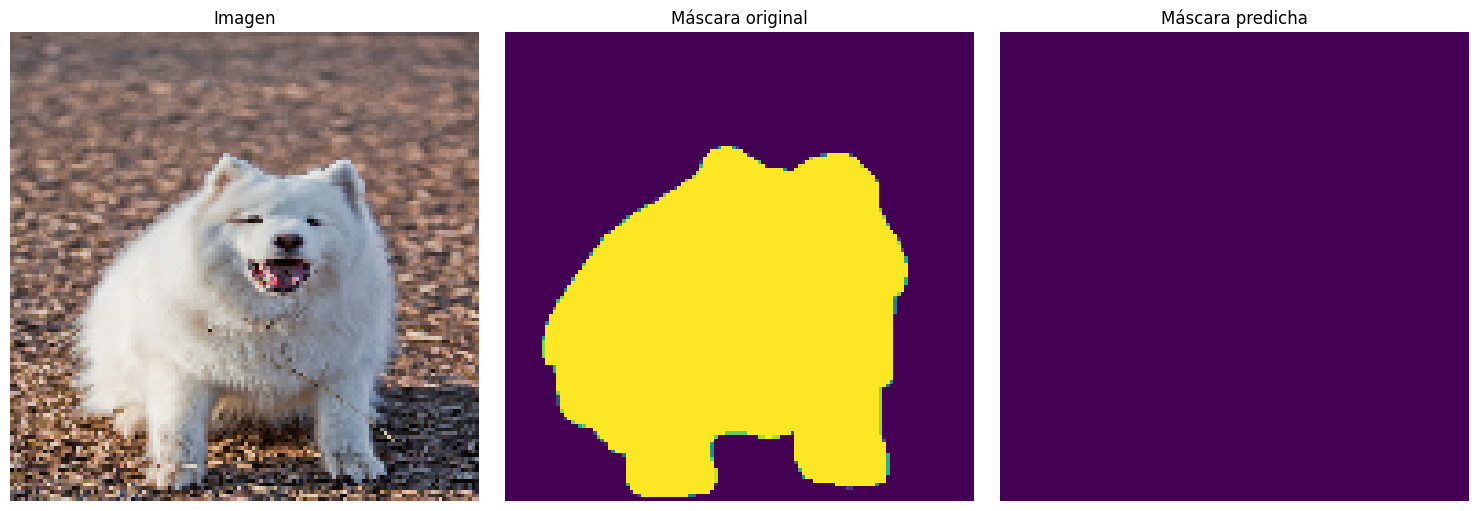

In [ ]:
# Crear un subplot con 1 fila y 3 columnas
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Graficar en cada subplot
axs[0].imshow(images[0,...])
axs[0].set_title('Imagen')
axs[0].axis('off')

axs[1].imshow(masks[0,...])
axs[1].set_title('Máscara original')
axs[1].axis('off')

axs[2].imshow(tf.where(prediction[0,...]>0.5,1.0,0.0))
axs[2].set_title('Máscara predicha')
axs[2].axis('off')

# Ajustar el espacio entre los subplots
plt.tight_layout()

# Mostrar el gráfico
plt.show()